In [5]:

import pandas as pd
import numpy as np

import pywt
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM,BatchNormalization, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn import preprocessing
import random
from sklearn.feature_selection import mutual_info_regression






In [6]:
import tensorflow as tf

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  0


In [7]:
tf.config.list_physical_devices('GPU')

[]

In [8]:


# Low pass filter
def lowpassfilter(signal, layers = 3, wavelet="sym15"):

    coeff = pywt.wavedec(signal, wavelet, mode="constant")

    for i in range(0,layers):
        coeff[i].fill(0)
    reconstructed_signal = pywt.waverec(coeff, wavelet, mode="constant" )
    return reconstructed_signal

# Transform data into LSTM input format
def create_dataset(dataset, y_column=0, look_back=1):
	dataX, dataY = [], []
	for i in range(dataset.shape[0]-look_back-1):
		a = dataset[i:(i+look_back), :]
		dataX.append(a)
		dataY.append(dataset[i + look_back, y_column])
	return np.array(dataX), np.array(dataY)

# Read and prepare data


path_datasets="/Users/danielpele/Library/CloudStorage/GoogleDrive-danpele@ase.ro/Other \
computers/Asus/G/PROIECTE/Understanding Digital Assets/Cod/Datasets/"

#path_datasets="D:/G/PROIECTE/Understanding Digital Assets/Cod/Datasets/"

df = pd.read_csv(path_datasets+"btc_sentiment_predictions.csv", index_col=0, low_memory=False)
df.interpolate(method='linear', inplace=True)
df['Volume']=np.log(df['Volume'])


In [9]:
import pandas as pd

def add_lagged_columns(df, max_lag):
    """
    Adds lagged values of all columns in the DataFrame up to a specified maximum lag.

    :param df: pandas DataFrame
    :param max_lag: integer, maximum number of periods to lag
    :return: DataFrame with original and lagged columns up to the max_lag
    """
    lagged_df = df.copy()
    for lag in range(1, max_lag + 1):
        for column in df.columns:
            lagged_df[f'{column}_lagged_{lag}'] = df[column].shift(lag)
    return lagged_df





def select_relevant_features(df, target_column, n_features):
    """
    Selects the top n features based on mutual information score with the target column.

    :param df: pandas DataFrame containing the features and target.
    :param target_column: the name of the target column.
    :param n_features: number of top features to select.
    :return: DataFrame with only the selected features and the target.
    """
    # Filter columns 
    #lagged_features = [col for col in df.columns if '_lagged_' in col]
    lagged_features = [col for col in df.columns]
    # Ensure the target column is not in the features
    features = df[lagged_features]

    # Calculate mutual information scores
    mi_scores = mutual_info_regression(features, df[target_column])

    # Create a Series with feature names and their mutual information scores
    mi_scores = pd.Series(mi_scores, index=features.columns)

    # Select the top n features with the highest MI scores
    selected_features = mi_scores.nlargest(n_features).index

    # Return a DataFrame with only the selected features and the target
    return df[selected_features.to_list() + [target_column]]

# Example usage:
# Assuming you have a DataFrame 'df' and a target column 'target_col'
# selected_df = select_relevant_features(df, 'target_col', 5)

#=============== Final Function =============================

def Final_Data_Preparation(Data,target):


    #data = add_lagged_columns(Data,  max_lag=5)
    data=Data.dropna()
    selected_df = select_relevant_features(data, target, 20)

    return selected_df

In [10]:
target='Volume'
data = Final_Data_Preparation(df,target)
data=data.dropna()
data=data.iloc[:,:-1]
data.head()

,Volume,High,Open,Adj Close,Close,Low,Love,Haha,Wow,Comments,weighted_sentiment_negative,Total Interactions,Shares,weighted_sentiment_positive,weighted_sentiment_neutral,Sad,Angry,Likes,sentiment_intensity,final_sentiment_score
date,,,,,,,,,,,,,,,,,,,,
2015-01-05,17.598854,278.341003,265.084015,274.473999,274.473999,265.084015,0,0,0,0,0.000000,0,0,0.000000,0.000000,0,0,0,1.494833,0.593620
2015-01-06,16.961631,287.553009,274.610992,286.188995,286.188995,272.696014,0,0,0,46,560.177134,605,273,6.776883,38.045971,0,0,286,1.881081,0.966370
2015-01-07,17.029044,298.753998,286.076996,294.337006,294.337006,283.079010,0,0,0,28,278.770315,319,94,4.424540,35.805121,0,0,197,1.607967,0.747949
2015-01-08,16.810367,294.135010,294.135010,283.348999,283.348999,282.174988,0,0,0,0,0.000000,0,0,0.000000,0.000000,0,0,0,1.651166,1.221770
2015-01-09,16.745028,291.114014,282.382996,290.407990,290.407990,280.532990,0,0,0,80,66.570049,2226,725,66.785524,2092.644385,0,0,1421,1.694366,1.695591


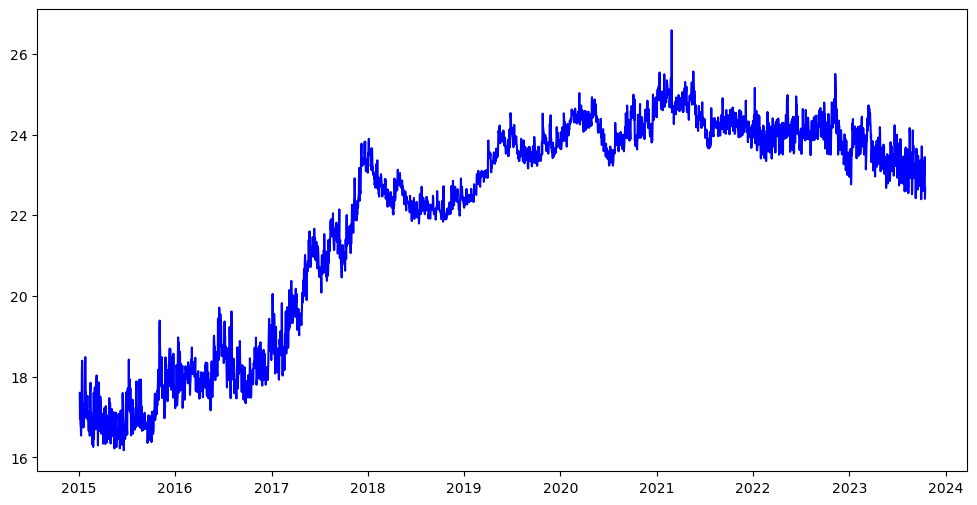

In [11]:
x=pd.to_datetime(data.index)
# Plot
plt.figure(figsize=(12, 6))
plt.plot(x,data['Volume'], color='blue')

plt.show()

In [12]:

col      = data.columns
ind      = data.index
scaler   = preprocessing.MinMaxScaler()
scaler_y = preprocessing.StandardScaler()

split   = int(round(0.7*data.shape[0]))


data1_1 = pd.DataFrame(scaler.fit_transform(data.iloc[:split,1:].values), columns=col[1:], index=ind[:split])
data1_2 = pd.DataFrame(scaler.transform(data.iloc[split:,1:].values), columns=col[1:], index=ind[split:])
data1   = pd.concat([data1_1, data1_2], axis=0)
data0_1 = pd.DataFrame(scaler_y.fit_transform(data.iloc[:split,0].values.reshape(-1,1)), columns=[col[0]], index=ind[:split])
data0_2 = pd.DataFrame(scaler_y.transform(data.iloc[split:,0].values.reshape(-1,1)), columns=[col[0]], index=ind[split:])
data0   = pd.concat([data0_1, data0_2], axis=0)


# Combine scaled data
data = pd.concat([data0, data1], axis=1)

# Check the shape and content of data before applying the filter
print("Shape before filtering:", data.iloc[:,3:].shape)
print(data.iloc[:,3:].head())

# Apply lowpassfilter and check the output
filtered_data = data.iloc[:,3:].apply(lowpassfilter, axis=0, args=(3,))
print("Shape after filtering:", filtered_data.shape)
print(filtered_data.head())

# Ensure we drop the last row if it's necessary
filtered_data = filtered_data.iloc[:-1,:]

# Create data3 DataFrame with correct indices and columns
data3 = pd.DataFrame(filtered_data.values, index=ind[:filtered_data.shape[0]], columns=col[3:])

# Combine with the rest of the data
data = pd.concat([data.iloc[:,:3], data3], axis=1)


Shape before filtering: (3206, 17)
            Adj Close     Close       Low  Love  Haha  Wow  Comments  \
date                                                                   
2015-01-05   0.001680  0.001680  0.001686   0.0   0.0  0.0  0.000000   
2015-01-06   0.001884  0.001884  0.001823   0.0   0.0  0.0  0.000482   
2015-01-07   0.002026  0.002026  0.002010   0.0   0.0  0.0  0.000294   
2015-01-08   0.001835  0.001835  0.001994   0.0   0.0  0.0  0.000000   
2015-01-09   0.001958  0.001958  0.001964   0.0   0.0  0.0  0.000839   

            weighted_sentiment_negative  Total Interactions    Shares  \
date                                                                    
2015-01-05                     0.000000            0.000000  0.000000   
2015-01-06                     0.010263            0.000870  0.000558   
2015-01-07                     0.005108            0.000459  0.000192   
2015-01-08                     0.000000            0.000000  0.000000   
2015-01-09            

In [13]:
lstm_input    = 1
dataX, dataY = create_dataset(data.values,0,lstm_input)



dfY  = data.iloc[lstm_input:,0]

dataY  = dfY.iloc[:-1].values
trainX = dataX[:split,:,:]
trainY = dataY[:split]
testX  = dataX[len(trainY):,:,:]
testY  = dataY[len(trainY):]

# Define sizes for validation and test sets
val_size = int(len(dataX) * 0.1)
test_size = int(len(dataX) * 0.2)

# Sequential Split into Training, Validation, and Test Sets
X_train, X_val_test = dataX[:-val_size - test_size], dataX[-val_size - test_size:]
y_train, y_val_test = dataY[:-val_size - test_size], dataY[-val_size - test_size:]

X_val, X_test = X_val_test[:val_size], X_val_test[val_size:]
y_val, y_test = y_val_test[:val_size], y_val_test[val_size:]


In [14]:
# Define LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dropout, Dense, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
import tensorflow as tf
from datetime import datetime
from packaging import version
%load_ext tensorboard
# Define the Keras TensorBoard callback.
logdir="logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)


# Define the LSTM model
model = Sequential()
model.add(Bidirectional(LSTM(256, return_sequences=True, input_shape=(trainX.shape[1], trainX.shape[2]), recurrent_dropout=0.2)))
model.add(Dropout(0.3))

model.add(Bidirectional(LSTM(128, return_sequences=False, recurrent_dropout=0.2)))
model.add(Dropout(0.3))

model.add(Dense(1, kernel_regularizer=l2(0.01)))

# Compile the model
optimizer = Adam(learning_rate=0.0005)
model.compile(optimizer=optimizer, loss='mean_squared_error')

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)


def lr_schedule(epoch):
    # Example learning rate calculation
    learning_rate = 0.001 * (0.1 ** (epoch // 10))
    return np.float32(learning_rate)  # Explicitly cast to float32

# Then, when setting up your callbacks, you use:
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lr_schedule, verbose=0)


# Train the model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, batch_size=32,
                    callbacks=[early_stopping, model_checkpoint, lr_scheduler,tensorboard_callback], verbose=1)

model.save('LSTM.keras') 

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 31s 417ms/step - loss: 0.4222 - val_loss: 0.0774 - learning_rate: 0.0010
Epoch 2/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0385 - val_loss: 0.0503 - learning_rate: 0.0010
Epoch 3/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0331 - val_loss: 0.0368 - learning_rate: 0.0010
Epoch 4/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0281 - val_loss: 0.0293 - learning_rate: 0.0010
Epoch 5/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0241 - val_loss: 0.0199 - learning_rate: 0.0010
Epoch 6/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0220 - val_loss: 0.0173 - learning_rate: 0.0010
Epoch 7/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0209 - val_loss: 0.0198 - learning_rate: 0.0010
Epoch 8/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0190 - val_loss: 0.0210 - learning_rate: 0.0010
Epoch 9/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0196 - val_loss: 0.0272 - learning_rate: 0.0010
Epoch 10/100
71/

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 1, 512)         │       567,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1, 512)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 256)            │       656,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,671,813 (14.01 MB)

 Trainable params: 1,223,937 (4.67 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,447,876 (9.34 MB)

Validation RMSE (Scaled Data): 0.1038221197196062
Test RMSE (Scaled Data): 0.12208197483389874
Validation R2: 0.328
Test R2: 0.550


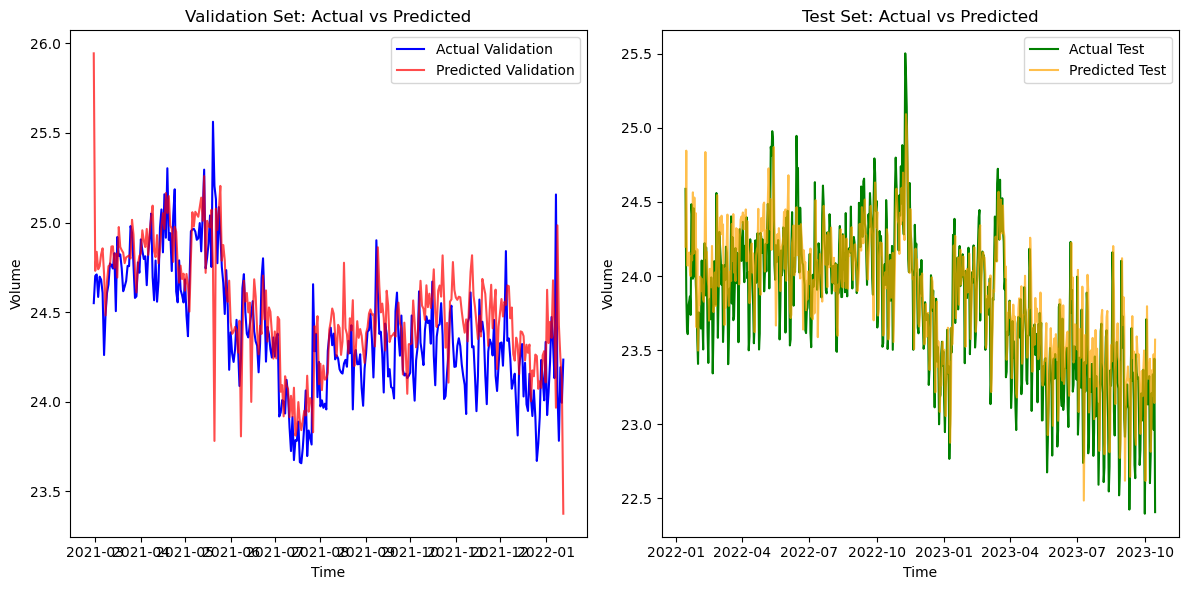

Validation RMSE: 0.104
Test RMSE: 0.122


In [15]:
# Make predictions
# Function to calculate and print evaluation metrics
from sklearn.metrics import r2_score
def evaluate_model(actual, predicted, name='Dataset'):
    mae = mean_absolute_error(actual[0], predicted[:,0])
    mse = mean_squared_error(actual[0], predicted[:,0])
    print(f'{name} Score: {mae:.2f} MAE, {mse:.2f} MSE')

model.summary()

# Predict on Validation and Test Sets
yhat_val = model.predict(X_val, verbose=0)
yhat_test = model.predict(X_test, verbose=0)

# Compute RMSE on the scaled data
rmse_val = np.sqrt(mean_squared_error(y_val, yhat_val))
rmse_test = np.sqrt(mean_squared_error(y_test, yhat_test))
print(f'Validation RMSE (Scaled Data): {rmse_val}')
print(f'Test RMSE (Scaled Data): {rmse_test}')

# Calculate R2 score for Validation and Test Sets
r2_val = r2_score(y_val, yhat_val)
r2_test = r2_score(y_test, yhat_test)
print(f'Validation R2: {r2_val:.3f}')
print(f'Test R2: {r2_test:.3f}')
# Invert scaling for predictions and actual values using the target transformer
yhat_val_inverted = scaler_y.inverse_transform(yhat_val)
yhat_test_inverted = scaler_y.inverse_transform(yhat_test)


# Reshape before inverse transform
y_val_inverted = scaler_y.inverse_transform(y_val.reshape(-1, 1)).flatten() # Reshape before inverse transform
y_test_inverted = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten() # Reshape before inverse transform
# Plot Predicted vs Actual Values after inverting scaling for Validation Set
plt.figure(figsize=(12, 6))

# Plot for Validation Set
plt.subplot(1, 2, 1)
plt.plot(pd.to_datetime(data.index[-val_size - test_size:-test_size]), y_val_inverted, label='Actual Validation', color='blue')
plt.plot(pd.to_datetime(data.index[-val_size - test_size:-test_size]), yhat_val_inverted, label='Predicted Validation', color='red', alpha=0.7)
plt.title('Validation Set: Actual vs Predicted')
plt.xlabel('Time')
plt.ylabel(target)
plt.legend()

# Plot for Test Set
plt.subplot(1, 2, 2)
plt.plot(pd.to_datetime(data.index[-test_size:]), y_test_inverted, label='Actual Test', color='green')
plt.plot(pd.to_datetime(data.index[-test_size:]), yhat_test_inverted, label='Predicted Test', color='orange', alpha=0.7)
plt.title('Test Set: Actual vs Predicted')
plt.xlabel('Time')
plt.ylabel(target)
plt.legend()

plt.tight_layout()
plt.show()

print(f'Validation RMSE: {rmse_val:.3f}')
print(f'Test RMSE: {rmse_test:.3f}')



In [16]:
data.index

Index(['2015-01-05', '2015-01-06', '2015-01-07', '2015-01-08', '2015-01-09',
       '2015-01-10', '2015-01-11', '2015-01-12', '2015-01-13', '2015-01-14',
       ...
       '2023-10-06', '2023-10-07', '2023-10-08', '2023-10-09', '2023-10-10',
       '2023-10-11', '2023-10-12', '2023-10-13', '2023-10-14', '2023-10-15'],
      dtype='object', name='date', length=3206)

In [17]:
data.index[-val_size - test_size:-test_size]

Index(['2021-02-28', '2021-03-01', '2021-03-02', '2021-03-03', '2021-03-04',
       '2021-03-05', '2021-03-06', '2021-03-07', '2021-03-08', '2021-03-09',
       ...
       '2022-01-04', '2022-01-05', '2022-01-06', '2022-01-07', '2022-01-08',
       '2022-01-09', '2022-01-10', '2022-01-11', '2022-01-12', '2022-01-13'],
      dtype='object', name='date', length=320)

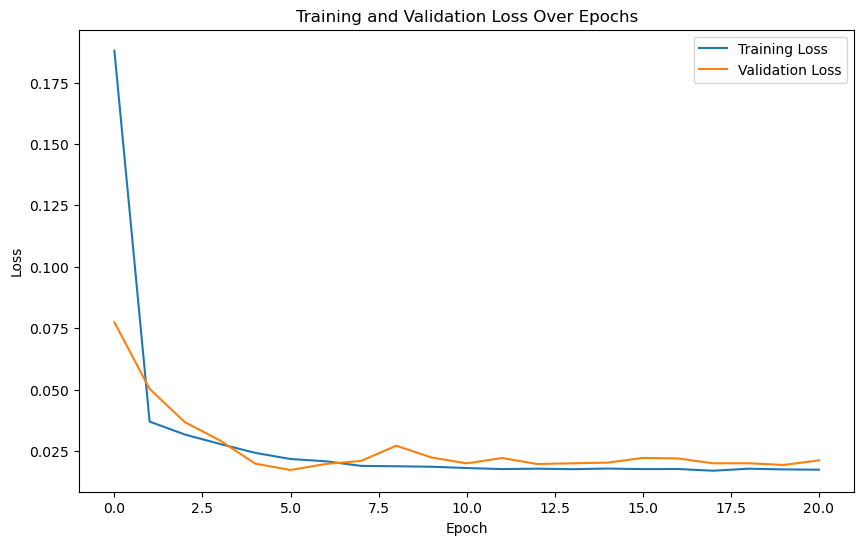

In [18]:
import matplotlib.pyplot as plt

# Plot the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


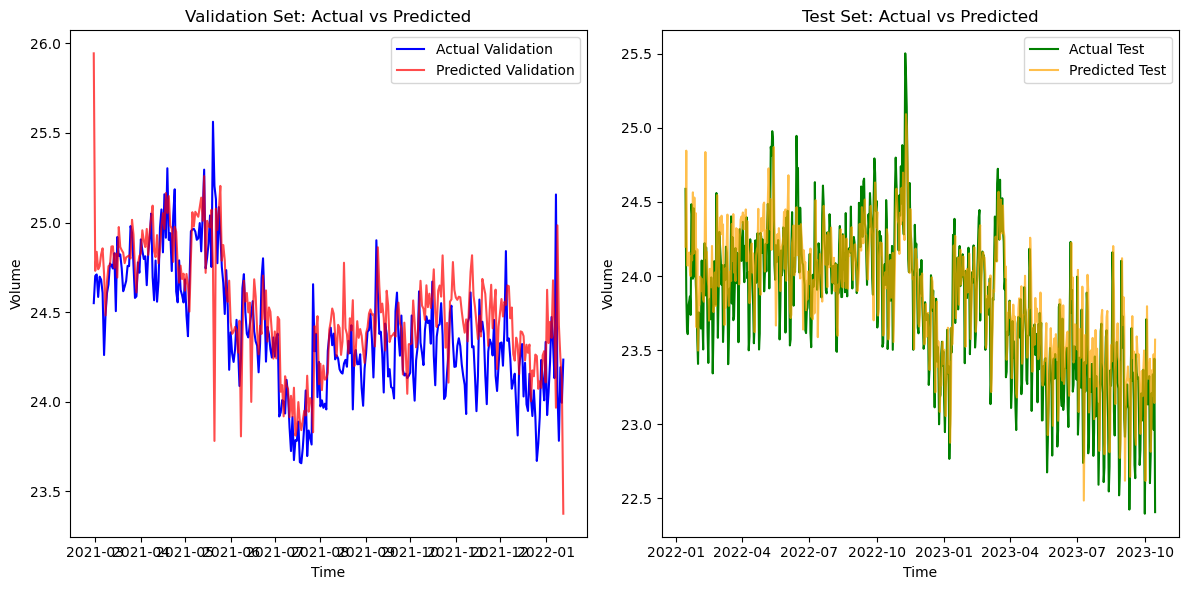

In [19]:
# Plot Predicted vs Actual Values after inverting scaling for Validation Set
plt.figure(figsize=(12, 6))

# Plot for Validation Set
plt.subplot(1, 2, 1)
plt.plot(pd.to_datetime(data.index[-val_size - test_size:-test_size]), y_val_inverted, label='Actual Validation', color='blue')
plt.plot(pd.to_datetime(data.index[-val_size - test_size:-test_size]), yhat_val_inverted, label='Predicted Validation', color='red', alpha=0.7)
plt.title('Validation Set: Actual vs Predicted')
plt.xlabel('Time')
plt.ylabel(target)
plt.legend()

# Plot for Test Set
plt.subplot(1, 2, 2)
plt.plot(pd.to_datetime(data.index[-test_size:]), y_test_inverted, label='Actual Test', color='green')
plt.plot(pd.to_datetime(data.index[-test_size:]), yhat_test_inverted, label='Predicted Test', color='orange', alpha=0.7)
plt.title('Test Set: Actual vs Predicted')
plt.xlabel('Time')
plt.ylabel(target)
plt.legend()

plt.tight_layout()
plt.show()

In [20]:
# Compute RMSE on the scaled data
rmse_val = np.sqrt(mean_squared_error(y_val, yhat_val))
rmse_test = np.sqrt(mean_squared_error(y_test, yhat_test))
print(f'Validation RMSE (Scaled Data): {rmse_val}')
print(f'Test RMSE (Scaled Data): {rmse_test}')

# Calculate R2 score for Validation and Test Sets
r2_val = r2_score(y_val, yhat_val)
r2_test = r2_score(y_test, yhat_test)
print(f'Validation R2: {r2_val:.3f}')
print(f'Test R2: {r2_test:.3f}')

Validation RMSE (Scaled Data): 0.1038221197196062
Test RMSE (Scaled Data): 0.12208197483389874
Validation R2: 0.328
Test R2: 0.550


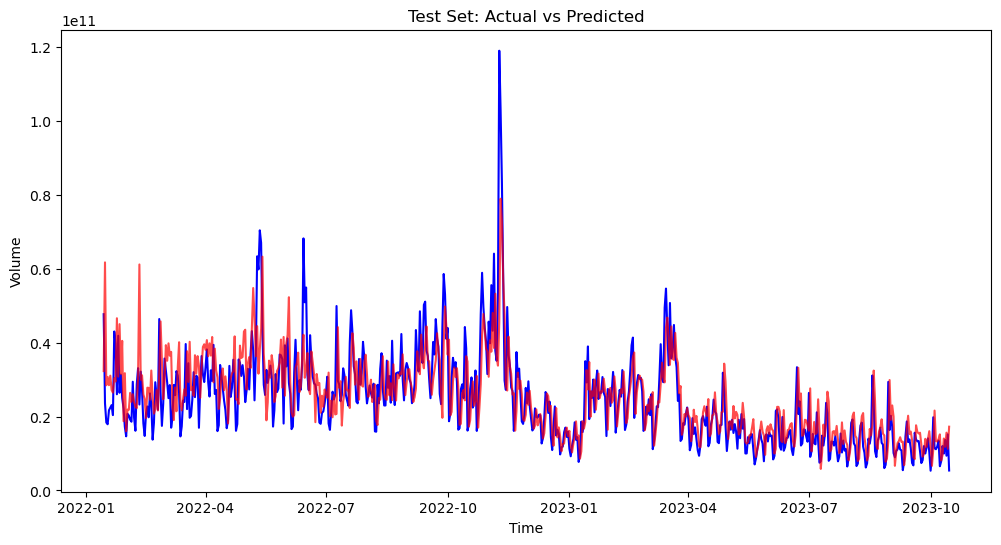

In [21]:
# Plot Predicted vs Actual Values after inverting scaling for Validation Set
plt.figure(figsize=(12, 6))


plt.plot(pd.to_datetime(data.index[-test_size:]), np.exp(y_test_inverted), label='Actual Test', color='blue')
plt.plot(pd.to_datetime(data.index[-test_size:]), np.exp(yhat_test_inverted), label='Predicted Test', color='red', alpha=0.7)
plt.title('Test Set: Actual vs Predicted')
plt.xlabel('Time')#plt.tight_layout()


plt.ylabel(target)
plt.savefig('LSTM_predictions.png', transparent=True, bbox_inches='tight', dpi=300)
plt.show()